# ENRON

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import sys
sys.path.append("../")
sys.path.append("../../..")

In [74]:
from json import dumps, loads
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as skLogisticRegression
from sklearn.metrics import (classification_report, f1_score, precision_score, recall_score)
from tqdm import tnrange
import tensorflow as tf

from mlsql import BinaryLogisticRegression, InfluenceRanker, AutoFixer, HumanFixer, OracleFixer
from processor import ENRONProcessor

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

In [52]:
seed = 750668400
test_train_split_ratio = 0.5
corrupt_rate = 0.50
corrupt_type = "deal"
neg_size = 3

In [80]:
proc = ENRONProcessor(seed=seed, corrupt_word="http", corrupt_rate=corrupt_rate, sparse=False)
    
Xcorr, ycorr, sel_corrupt = proc.get_corrupted()
Xclean, yclean = proc.get_clean()
print(f"Dataset: {Xcorr.shape}")

Dataset: (4137, 3362)


In [85]:
graph = tf.Graph()
with graph.as_default(), graph.device("/CPU:0"):
    model = BinaryLogisticRegression(Xcorr, ycorr, seed)
    ranker = InfluenceRanker(model, on=proc.complain)
    fixer = OracleFixer(Xclean, yclean, sel_corrupt)
    _, C, Q = proc.complain(model, return_value=True)
graph.finalize()

# Search for 1.5 * K
K = int(sel_corrupt.sum() * 1.5)
Qs = np.empty((K,))

with tf.Session(graph=graph) as sess:
    sess.run(model.initop)
    sess.run(ranker.initop)

    now = time()
    for k in tnrange(K):
        model.fit(sess, method="scipy")
        rank = ranker.predict(sess)
        fixer.fix(model, rank, sess)
        Qs[k] = sess.run(Q)

In [82]:
delta = np.ones(model.X[0].shape[0])
delta[fixer.get_deletions()[:K]] = 0
print(classification_report(sel_corrupt, 1 - delta))

              precision    recall  f1-score   support

       False       0.86      0.86      0.86      3642
        True       0.00      0.00      0.00       495

    accuracy                           0.76      4137
   macro avg       0.43      0.43      0.43      4137
weighted avg       0.76      0.76      0.76      4137



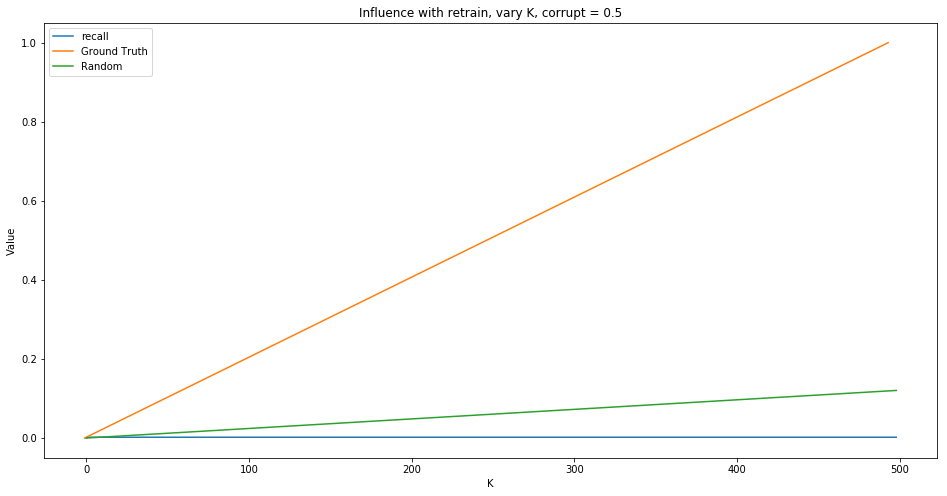

In [83]:
recalls = np.empty(len(fixer.get_deletions()))
delta = np.ones(model.X[0].shape[0])


k = range(len(fixer.get_deletions()))

for i in k:
    delta[fixer.get_deletions()[i]] = 0
    recalls[i] = recall_score(sel_corrupt, 1 - delta)

plt.figure(figsize=(16,8))

plt.plot(k, recalls, label = "recall")
ntruth = fixer.truth.sum()
plt.plot(range(-1, ntruth-1), np.linspace(0, 1, ntruth), label = "Ground Truth")

rand_prob = ntruth / len(fixer.truth)
plt.plot(k, k * rand_prob / ntruth, label = "Random")

plt.plot()
plt.xlabel("K")
plt.ylabel("Value")
plt.title(f"Influence with retrain, vary K, corrupt = {corrupt_rate}")
plt.legend()